# Remote Sensing Exercise - Part A

In this  exercise you will get a rough idea of how we process the LST data and calculate zonal statistics for our DB.

## Data

The data we use are from the new [LST_cci](https://climate.esa.int/en/projects/land-surface-temperature/about/) Terra MODIS product. They cover the region of Mexico and refer to the year 2018.

## Steps

What we will do:

1. Open the netCDF4 file and inspect its attributes.
2. Visualize the LST, VZA and LST_uncertainty data.
3. Quality filter the LST data using the uncertainties.
4. Calculate the LST min, mean, max and StD for Mexico City for every cloud-free day of 2018.


In [ ]:
# First load your Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# After mounting, check folders in left side-bar
# If this code does not work, you can use the "Mount Drive" button in the left side-bar

Mounted at /content/drive


In [ ]:
# Import the modules we will need
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io

In [ ]:
# Set relevant directories
import os

# Your own baseline directory - if mounted under MyDrive, do not change.
BASE_DIR = os.path.join('/content/drive/MyDrive/BUCSS22')
print('BASE_DIR: ',BASE_DIR)

# Create a link to notebooks directory
YOUR_NAME = "Panagiotis_Lecturer" # Name of your own folder
NOTEBOOKS_DIR = os.path.join(BASE_DIR, YOUR_NAME, 'notebooks')
print('NOTEBOOKS_DIR: ',NOTEBOOKS_DIR)

# Other relevant folders
LST_DIR         = os.path.join(BASE_DIR, 'DATA_SHARE', 'LST')
print('DATA_DIR: ',LST_DIR)

BASE_DIR:  /content/drive/MyDrive/BUCSS22
NOTEBOOKS_DIR:  /content/drive/MyDrive/BUCSS22/Panagiotis_Lecturer/notebooks
DATA_DIR:  /content/drive/MyDrive/BUCSS22/DATA_SHARE/LST


## Let's Start...

In [ ]:
# Let's start by opening the netCDF4 file with the LST data
fn_nc = os.path.join(LST_DIR, "ESACCI-LST-MODIST-RUBMEX-2018-D.nc")

with netCDF4.Dataset(fn_nc) as nc:
    # and then print the global attributes.
    print(nc)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    esacci_lst_product: MODIST
    region: RUBMEX
    height: 335
    width: 470
    easternmost_lon: -97.22
    westernmost_lon: -101.91
    southernmost_lat: 18.41
    northernmost_lat: 21.75
    res: 0.01
    overpass: Daytime
    year: 2018
    date_created: Created: 2020-09-23 21:26
    dimensions(sizes): time(341), lat(335), lon(470)
    variables(dimensions): float32 lat(lat), float32 lon(lon), int8 crc(), float64 time(time), int16 lst(time, lat, lon), int16 lst_uncertainty(time, lat, lon), int16 satze(time, lat, lon), int16 soltime(time, lat, lon)
    groups: 


In [ ]:
# Next, let's print the attributes of the LST variable.
with netCDF4.Dataset(fn_nc) as nc:
    print(nc["lst"])

<class 'netCDF4._netCDF4.Variable'>
int16 lst(time, lat, lon)
    _FillValue: -32768
    least_significant_digit: 2
    long_name: Land Surface Temperature
    units: Celsius
    valid_range: [-8315  7685]
    scale_factor: 0.01
    add_offset: 273.15
    grid_mapping: crc
unlimited dimensions: time
current shape = (341, 335, 470)
filling on


In [ ]:
# Let's start by reading some data
with netCDF4.Dataset(fn_nc) as nc:
    datacube_lst = nc["lst"][:]
    datacube_unc = nc["lst_uncertainty"][:]
    datacube_satze = nc["satze"][:]

# and then print the shape of the three datacube
print("LST: ", datacube_lst.shape)
print("LST Uncertainty: ", datacube_unc.shape)
print("VZA: ", datacube_satze.shape)

LST:  (341, 335, 470)
LST Uncertainty:  (341, 335, 470)
VZA:  (341, 335, 470)


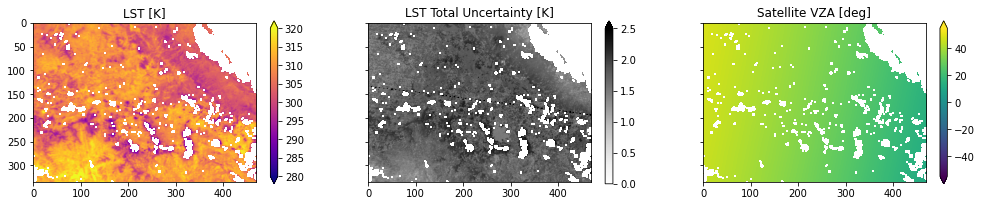

In [ ]:
# Now, let's see how do they look:

# Play arround with the band variable to see how they change over time.
band = 50

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=[17, 5])

im1 = axs[0].imshow(datacube_lst[band, ...], cmap="plasma", vmin=280, vmax=320)
im2 = axs[1].imshow(datacube_unc[band, ...], cmap="Greys", vmin=0, vmax=2.5)
im3 = axs[2].imshow(datacube_satze[band, ...], cmap="viridis", vmin=-55, vmax=55)

axs[0].set_title("LST [K]")
axs[1].set_title("LST Total Uncertainty [K]")
axs[2].set_title("Satellite VZA [deg]")

fig.colorbar(im1, ax=axs[0], extend="both", shrink=0.6)
fig.colorbar(im2, ax=axs[1], extend="max", shrink=0.6)
fig.colorbar(im3, ax=axs[2], extend="both", shrink=0.6)

plt.show()

The uncertainty associated with each LST observation differs from pixel to pixel. We generally want to keep the most accurate observations. First let's examine the distribution of the LST total uncertainty to get an idea of what is going on.

Text(0.5, 0, 'LST Total Uncertainty [K]')

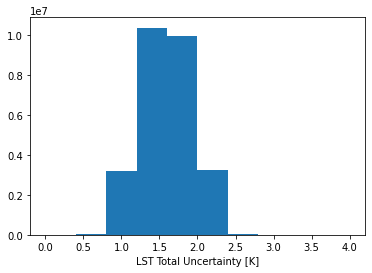

In [ ]:
plt.hist(datacube_unc.flatten(), bins=10, range=[0,4])
plt.xlabel("LST Total Uncertainty [K]")

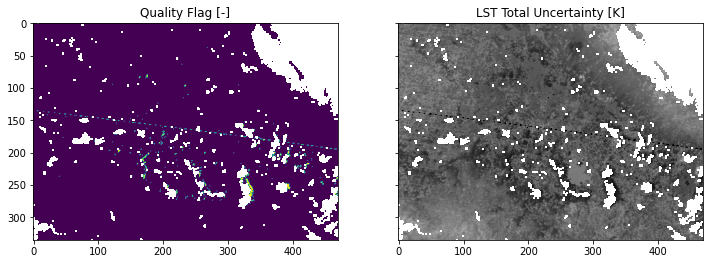

In [ ]:
# create a mask 
datacube_qf = datacube_unc >= 2.25

# Plot the result
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=[12, 6])

axs[0].imshow(datacube_qf[band, ...], cmap="viridis", vmin=0, vmax=1)
axs[1].imshow(datacube_unc[band, ...], cmap="Greys", vmin=0, vmax=2.5)

axs[0].set_title("Quality Flag [-]")
axs[1].set_title("LST Total Uncertainty [K]")

plt.show()


We want to keep only the purple pixels. All the rest need to go.

In [ ]:
# I will first Create a copy of the original array, so we can compare the before and after.
datacube_lst_copy = datacube_lst.copy()

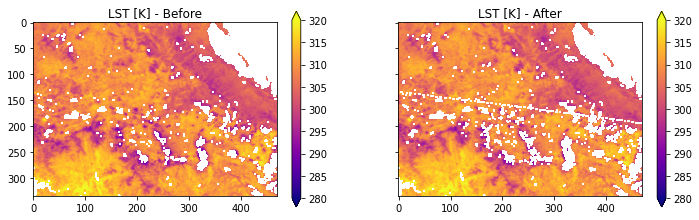

In [ ]:
# Now, let's mask the low-quality pixels
FILL_VALUE = -32768
datacube_lst[datacube_qf] = FILL_VALUE

# Update the array mask
datacube_lst = np.ma.masked_equal(datacube_lst, FILL_VALUE)

# Plot the result
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=[12, 6])

im1 = axs[0].imshow(datacube_lst_copy[band, ...], cmap="plasma", vmin=280, vmax=320)
im2 = axs[1].imshow(datacube_lst[band, ...], cmap="plasma", vmin=280, vmax=320)

axs[0].set_title("LST [K] - Before")
axs[1].set_title("LST [K] - After")

fig.colorbar(im1, ax=axs[0], extend="both", shrink=0.6)
fig.colorbar(im2, ax=axs[1], extend="both", shrink=0.6)

plt.show()

The stricter we are the more pixels we will discard. Just remember that the LST uncertainty for urban pixels is usually >2 K.

## Zonal Statistics

Let's calculate the daily mean, min, max, and StD LST for Mexico city.

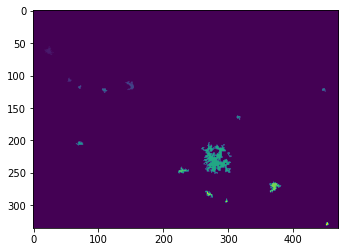

In [ ]:
# We will first load a raster layer with the urban boundaries
fn_tif = os.path.join(LST_DIR, "mexico_cities.tif")
cities = io.imread(fn_tif)

# This is how it looks:
plt.imshow(cities, cmap="viridis")

In [ ]:
# Notice that the spatial dimensions are exactly the same with the nc data
print(cities.shape)

(335, 470)


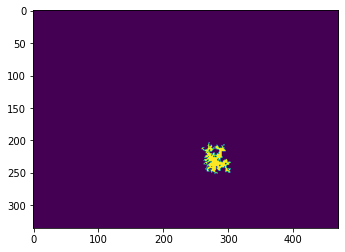

In [ ]:
# The value of the Mexico city pixels is equal to 9. We will use this to create a mask.
mexico_city = cities == 9

# I will also print the result.
plt.imshow(mexico_city, cmap="viridis")

In [ ]:
# Let's also count how many pixels there are in the mask
n = np.count_nonzero(mexico_city)

print(n)

924


Now let's use the city mask to select only the LST pixels we need for each day

In [ ]:
# For each day I will add a dictionary with the spatial mean, min, max and std in the lst `data`.
data = []

for lst, satze in zip(datacube_lst, datacube_satze):
    
    city_data = lst[mexico_city]
    
    daily_data = {
        "lst_mean": city_data.mean(),
        "lst_min": city_data.min(),
        "lst_max": city_data.max(),
        "lst_std": city_data.std(),
        "n_pxls": np.count_nonzero(city_data.count()) / n * 100,
        "vza_median": np.ma.median(satze[mexico_city]),

    }
    
    data.append(daily_data)

# Lastly, we will convert the list `data` into a dataframe:
df = pd.DataFrame(data)
df.head()
    

,lst_mean,lst_min,lst_max,lst_std,n_pxls,vza_median
0,296.690718,291.6,298.56,1.092407,0.108225,65.06
1,300.082707,294.14,305.59,1.681901,0.108225,2.69
2,--,--,--,--,0.000000,--
3,300.957438,294.92,305.12,1.477015,0.108225,29.16
4,301.870033,291.91,305.55,1.843053,0.108225,-52.27


In [ ]:
# The number of dataframe rows should be the same as the number of LST bands.
print(len(df))

341


We will also add a new column with each date.

In [ ]:
# First we need to retrieve the observation times
with netCDF4.Dataset(fn_nc) as nc:
    nc_times = netCDF4.num2date(nc["time"][:], nc["time"].units)
    t = [time.strftime("%Y-%m-%d") for time in nc_times]

# Then we will add it to the dataframe as a new column
df["datetime"] = pd.to_datetime(t, format="%Y-%m-%d") 

# and use it as index.
df.set_index("datetime", inplace=True)

df.head()

,lst_mean,lst_min,lst_max,lst_std,n_pxls,vza_median
datetime,,,,,,
2018-01-01,296.690718,291.6,298.56,1.092407,0.108225,65.06
2018-01-02,300.082707,294.14,305.59,1.681901,0.108225,2.69
2018-01-03,--,--,--,--,0.000000,--
2018-01-04,300.957438,294.92,305.12,1.477015,0.108225,29.16
2018-01-05,301.870033,291.91,305.55,1.843053,0.108225,-52.27


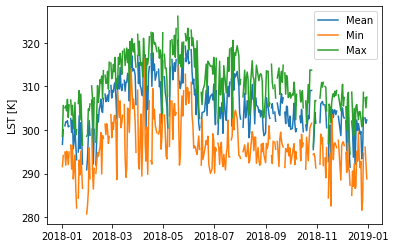

In [ ]:
# Let's plot the result
plt.plot(df["lst_mean"], label="Mean")
plt.plot(df["lst_min"], label="Min")
plt.plot(df["lst_max"], label="Max")
plt.ylabel("LST [K]")
plt.legend()

**Well Done!**

Now, we will now move to Part B, which focuses on data analysis.